
# Análise de Filmes IMDB: Exploração, Inferências e Conexões

Este notebook conduz uma análise exploratória de dados (EDA) sobre um conjunto de filmes extraído da base IMDB. O objetivo é compreender
padrões na avaliação (IMDB_Rating), nos aspectos numéricos e categóricos dos filmes, bem como explorar relações temporais e correlações entre variáveis. Após cada análise, são apresentadas inferências para contextualizar os resultados e estabelecer conexões entre os tópicos.


In [129]:
from datetime import datetime, timezone
from pathlib import Path
from collections import Counter
import os
import platform
import pickle
import pprint
import re
import subprocess
import sys
import warnings
import glob
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    classification_report, f1_score, precision_recall_curve,
    accuracy_score, ConfusionMatrixDisplay,
)
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVR

warnings.filterwarnings("ignore")
sns.set(style="whitegrid", palette="muted", color_codes=True)


### Download do Dataset

In [130]:
url = "https://drive.google.com/uc?export=download&id=1ALlF3rwaKi7Z1HptTYgMpscd5jlFeura"
csv_path = Path("desafio_indicium_imdb.csv")
if not csv_path.exists():
    gdown.download(url, str(csv_path), quiet=False)
df_original = pd.read_csv(csv_path)
df = df_original.copy()

In [131]:
df_shape = df.shape
print(f"O conjunto de dados original possui {df_shape[0]} linhas e {df_shape[1]} colunas.")

df.head()

O conjunto de dados original possui 999 linhas e 16 colunas.


,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"



## Estrutura Inicial do Dataset

O dataset contém registros de **999 filmes** e **16 colunas** na versão original. As colunas contemplam variáveis numéricas (por exemplo,
`Released_Year`, `IMDB_Rating`, `Meta_score`, `No_of_Votes`, `Gross`, `Runtime`), variáveis categóricas (`Certificate`, `Genre`) e textuais
(títulos, sinopses, nomes de estrelas). Essa diversidade permitirá analisar tanto a qualidade e a popularidade dos filmes quanto aspectos
temporais e comerciais.

Antes de prosseguir, é importante verificar lacunas no dataset, tratar algumas colunas para converter textos em números e criar novas variáveis derivadas.


In [132]:
def missing_summary(df):
    missing_count = df.isnull().sum()
    missing_percentage = (missing_count / len(df)) * 100
    missing_table = pd.DataFrame({'Missing Count': missing_count, 'Missing Percentage (%)': missing_percentage})
    missing_table = missing_table[missing_table['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)
    return missing_table

missing_df = missing_summary(df)
print("Resumo de valores ausentes por coluna:")
display(missing_df)

Resumo de valores ausentes por coluna:


,Missing Count,Missing Percentage (%)
Gross,169,16.916917
Meta_score,157,15.715716
Certificate,101,10.110110


In [133]:
rows_with_missing = df.isnull().any(axis=1).sum()
print(f"Número de linhas com pelo menos um valor ausente: {rows_with_missing} - {rows_with_missing/len(df):.2%}")

Número de linhas com pelo menos um valor ausente: 286 - 28.63%


Como cerca de **30%** das linhas têm ao menos um valor ausente, excluir essas observações levaria a uma perda relevante de informação.

Dessa forma, adotaremos **imputação** em vez de remoção: para `Certificate`, atribuiremos **"Not Rated"** aos registros faltantes; para `Gross` e `Meta_score`, **converteremos primeiro as colunas para formato numérico** e, em seguida, **imputaremos os valores ausentes**.


In [134]:
df['Certificate'] = df['Certificate'].fillna('Not Rated')

In [135]:
def to_minutes(runtime_str):
    if pd.isna(runtime_str):
        return np.nan
    m = re.search(r"(\d+)", str(runtime_str))
    return float(m.group(1)) if m else np.nan

if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

df['Runtime'] = df['Runtime'].apply(to_minutes)

df['Gross'] = pd.to_numeric(df['Gross'].astype(str).str.replace(',', ''), errors='coerce')

df['Meta_score'] = pd.to_numeric(df['Meta_score'], errors='coerce')

df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')

print("Após limpeza de dados e criação de variáveis derivadas:")
df.head()


Após limpeza de dados e criação de variáveis derivadas:


,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,The Godfather,1972.0,A,175.0,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
1,The Dark Knight,2008.0,UA,152.0,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
2,The Godfather: Part II,1974.0,A,202.0,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
3,12 Angry Men,1957.0,U,96.0,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0
4,The Lord of the Rings: The Return of the King,2003.0,U,201.0,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905.0


In [136]:
missing_df = missing_summary(df)
print("Resumo de valores ausentes por coluna:")
display(missing_df)

Resumo de valores ausentes por coluna:


,Missing Count,Missing Percentage (%)
Gross,169,16.916917
Meta_score,157,15.715716
Released_Year,1,0.100100


Após converter as colunas para os tipos desejados, observamos que `Released_Year` passou a apresentar **valores vazios**. Isso indica que havia registros incompatíveis com o formato numérico e, após a conversão, esses valores foram transformados em nulos (`NaN`).


In [137]:
index = df[df['Released_Year'].isnull()].index
df_original.loc[index]

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
965,966,Apollo 13,PG,U,140 min,"Adventure, Drama, History",7.6,NASA must devise a strategy to return Apollo 1...,77.0,Ron Howard,Tom Hanks,Bill Paxton,Kevin Bacon,Gary Sinise,269197,"173,837,933"


In [138]:
df.loc[index]

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
965,Apollo 13,NaN,U,140.0,"Adventure, Drama, History",7.6,NASA must devise a strategy to return Apollo 1...,77.0,Ron Howard,Tom Hanks,Bill Paxton,Kevin Bacon,Gary Sinise,269197,173837933.0


Como a única amostra com informação inconsistente sobre o ano de lançamento corresponde ao filme **Apollo 13**, podemos preencher esse valor com base no registro de lançamento; a seguir, corrigiremos essa amostra no conjunto de dados.


In [139]:
df["Released_Year"][index] = 1995

df.loc[index]

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
965,Apollo 13,1995.0,U,140.0,"Adventure, Drama, History",7.6,NASA must devise a strategy to return Apollo 1...,77.0,Ron Howard,Tom Hanks,Bill Paxton,Kevin Bacon,Gary Sinise,269197,173837933.0


Antes de preencher os valores ausentes em `Gross` e `Meta_score`, vamos analisar **como as ausências estão distribuídas** ao longo do tempo (por década de lançamento) e entre diferentes **gêneros principais**.

Essa verificação é importante porque a **ausência de dados não é aleatória**: ela pode estar mais concentrada em certas décadas ou gêneros, o que impacta a escolha da estratégia de imputação.

A seguir:

1. Criamos a coluna `Decade` para agrupar os filmes por década.
2. Calculamos a proporção de ausências em `Gross` e `Meta_score` por década e por gênero principal.
3. Definimos a estratégia de preenchimento:

   * Para `Meta_score`, usamos a **mediana** por década e gênero, recorrendo à mediana geral quando necessário.
   * Para `Gross`, utilizamos a **média por década**, e, se ainda faltar, substituímos pela mediana geral.

Com isso, conseguimos preservar a estrutura do conjunto de dados e reduzir a perda de informação causada por valores ausentes.


In [140]:
df['Decade'] = (df['Released_Year'] // 10) * 10

missing_by_decade = df.groupby('Decade').agg({
    'Gross': lambda x: x.isna().mean(),
    'Meta_score': lambda x: x.isna().mean()
}).round(3)

print("Proporção de ausências por década:")
print(missing_by_decade)

Proporção de ausências por década:
        Gross  Meta_score
Decade                   
1920.0  0.273       0.727
1930.0  0.458       0.167
1940.0  0.429       0.429
1950.0  0.446       0.286
1960.0  0.329       0.192
1970.0  0.224       0.132
1980.0  0.101       0.079
1990.0  0.067       0.107
2000.0  0.093       0.101
2010.0  0.112       0.169
2020.0  1.000       0.333


In [141]:
df['Primary_Genre'] = df['Genre'].str.split(',').str[0].str.strip()

missing_by_genre = df.groupby('Primary_Genre').agg({
    'Gross': lambda x: x.isna().mean(),
    'Meta_score': lambda x: x.isna().mean()
}).round(3)

print("\nProporção de ausências por gênero principal:")
print(missing_by_genre.head(10))


Proporção de ausências por gênero principal:
               Gross  Meta_score
Primary_Genre                   
Action         0.180       0.169
Adventure      0.153       0.111
Animation      0.183       0.085
Biography      0.102       0.102
Comedy         0.174       0.194
Crime          0.131       0.187
Drama          0.191       0.167
Family         0.000       0.000
Fantasy        1.000       1.000
Film-Noir      0.333       0.000


In [142]:
overall_med = df['Meta_score'].median()
group_med = df.groupby(['Decade', 'Primary_Genre'])['Meta_score'].transform('median')

df['Meta_score'] = df['Meta_score'].fillna(group_med).fillna(overall_med)

In [143]:
overall_med = df['Gross'].median()
group_med = df.groupby(['Decade'])['Gross'].transform('mean')
df['Gross'] = df['Gross'].fillna(group_med).fillna(overall_med)

In [144]:
missing_df = missing_summary(df)
print("Resumo de valores ausentes por coluna:")
display(missing_df)

Resumo de valores ausentes por coluna:


,Missing Count,Missing Percentage (%)



## Análise da Variável Alvo: IMDB_Rating

A variável **IMDB_Rating** representa a nota média atribuída pelos usuários da plataforma. Ela é contínua e varia entre 0 e 10. Para
compreender sua distribuição, analisaremos estatísticas descritivas e um histograma com densidade.


In [145]:
rating_desc = df['IMDB_Rating'].describe().round(3)
print("Estatísticas descritivas do IMDB_Rating:")
display(rating_desc.to_frame(name='IMDB_Rating'))

Estatísticas descritivas do IMDB_Rating:


,IMDB_Rating
count,999.000
mean,7.948
std,0.272
min,7.600
25%,7.700
50%,7.900
75%,8.100
max,9.200


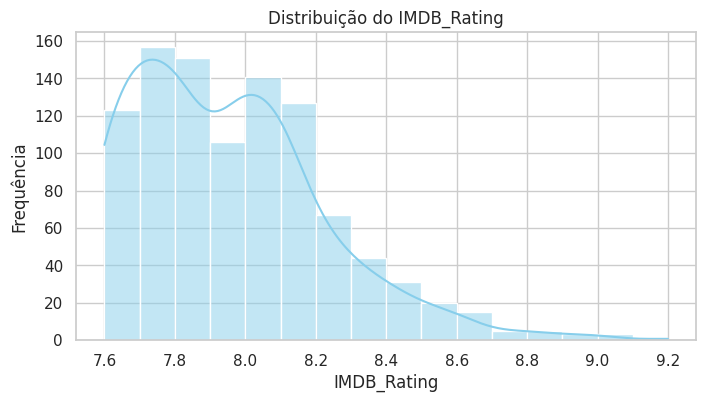

In [146]:
plt.figure(figsize=(8,4))
sns.histplot(df['IMDB_Rating'], bins=16, kde=True, color='skyblue')
plt.title('Distribuição do IMDB_Rating')
plt.xlabel('IMDB_Rating')
plt.ylabel('Frequência')
plt.show()


### Inferências sobre a Distribuição do IMDB_Rating

A distribuição das notas IMDB apresenta uma **forma aproximadamente normal**, centrada em torno de 7,95 e com desvio padrão de ~0,27.
Isso indica que a maior parte dos filmes no conjunto é bem avaliada, concentrando-se entre 7,7 e 8,1. Os valores mínimo (7,6) e máximo
(9,2) revelam que não há outliers extremos, isto é, a base reúne principalmente filmes que receberam reconhecimento positivo.

Do ponto de vista de modelagem, essa distribuição quase simétrica favorece algoritmos que assumem normalidade dos dados. Também sugere
que diferenciações mais sutis entre as características dos filmes serão necessárias para explicar variações de nota.



## Análise das Variáveis Numéricas

Agora examinaremos as principais variáveis quantitativas: `Meta_score`, `No_of_Votes`, `Gross`, `Runtime` e `Released_Year`.
Além de estatísticas descritivas, visualizamos distribuições individuais para `Meta_score` e `Runtime`.


In [147]:
numeric_cols = ['IMDB_Rating','Meta_score','No_of_Votes','Gross','Runtime','Released_Year']

numeric_desc = df[numeric_cols].describe().T.round(2)
print("Estatísticas descritivas das variáveis numéricas:")
display(numeric_desc)

Estatísticas descritivas das variáveis numéricas:


,count,mean,std,min,25%,50%,75%,max
IMDB_Rating,999.0,7.95,2.700000e-01,7.6,7.7,7.9,8.1,9.2
Meta_score,999.0,78.40,1.180000e+01,28.0,72.0,79.0,87.0,100.0
No_of_Votes,999.0,271621.42,3.209126e+05,25088.0,55471.5,138356.0,373167.5,2303232.0
Gross,999.0,64575239.34,1.012590e+08,1305.0,4897939.0,27298285.0,75308914.5,936662225.0
Runtime,999.0,122.87,2.810000e+01,45.0,103.0,119.0,137.0,321.0
Released_Year,999.0,1991.22,2.330000e+01,1920.0,1976.0,1999.0,2009.0,2020.0


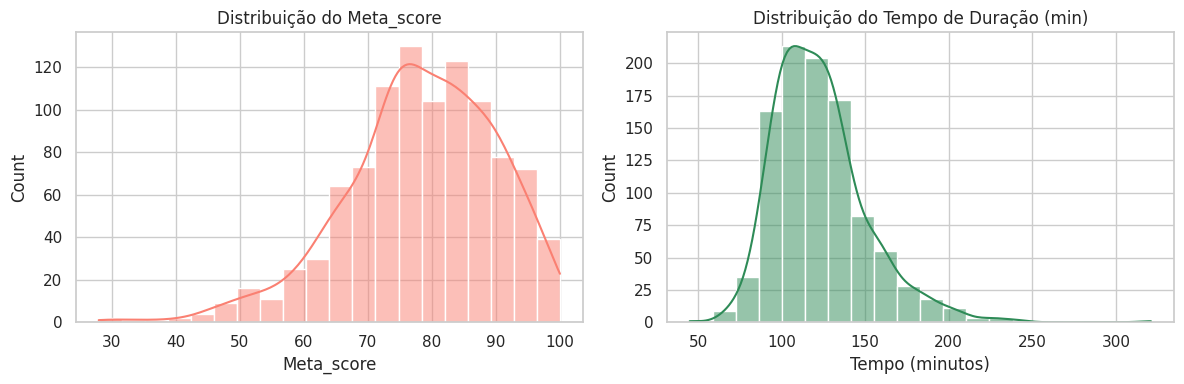

In [148]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df['Meta_score'].dropna(), bins=20, kde=True, ax=axes[0], color='salmon')
axes[0].set_title('Distribuição do Meta_score')
axes[0].set_xlabel('Meta_score')

sns.histplot(df['Runtime'].dropna(), bins=20, kde=True, ax=axes[1], color='seagreen')
axes[1].set_title('Distribuição do Tempo de Duração (min)')
axes[1].set_xlabel('Tempo (minutos)')
plt.tight_layout()
plt.show()


### Inferências sobre Variáveis Numéricas

* **Meta_score**: a distribuição tende a ser bimodal, sugerindo a existência de dois grupos de filmes: aqueles com avaliação crítica
mais elevada (picos acima de 80) e outro grupo com avaliações mais moderadas (em torno de 60–70). Embora não haja uma correlação muito
forte com o IMDB_Rating (r ≈ 0,27), notas altas no Meta_score tendem a acompanhar avaliações positivas do público.

* **No_of_Votes**: apresenta grande variação, com mediana em torno de 173 mil votos e máximo acima de 2,3 milhões. A correlação
moderada com o IMDB_Rating (r ≈ 0,48) indica que filmes mais votados tendem a ter avaliações ligeiramente maiores, refletindo
popularidade e engajamento do público.

* **Gross**: a bilheteria média é de aproximadamente US$ 68 milhões, mas a distribuição é bastante assimétrica: poucos
filmes alcançam receitas muito elevadas. A correlação com IMDB_Rating é baixa (≈ 0,10), sugerindo que sucesso comercial e avaliação de
qualidade não são diretamente proporcionais.

* **Runtime**: a duração média é de cerca de 123 minutos, com a maioria dos filmes entre 110 e 138 minutos. Existe correlação
moderada (≈ 0,24) com IMDB_Rating, indicando que filmes ligeiramente mais longos tendem a ser um pouco melhor avaliados, possivelmente
por permitirem desenvolvimento narrativo mais completo.

* **Released_Year**: o ano de lançamento mostra correlação negativa com a nota (≈ -0,13), ou seja, filmes mais antigos possuem, em
média, notas um pouco mais altas. Esse efeito pode refletir a sobrevivência de clássicos no imaginário popular, enquanto filmes
recentes ainda não atingiram status de cult.



## Análise de Variáveis Categóricas: Gêneros

Os filmes geralmente pertencem a múltiplos gêneros. Para estudar a popularidade e o desempenho por categoria, as entradas da coluna `Genre`
serão separadas (explode) e analisadas individualmente. Avaliaremos a frequência de cada gênero e suas notas médias no IMDB.


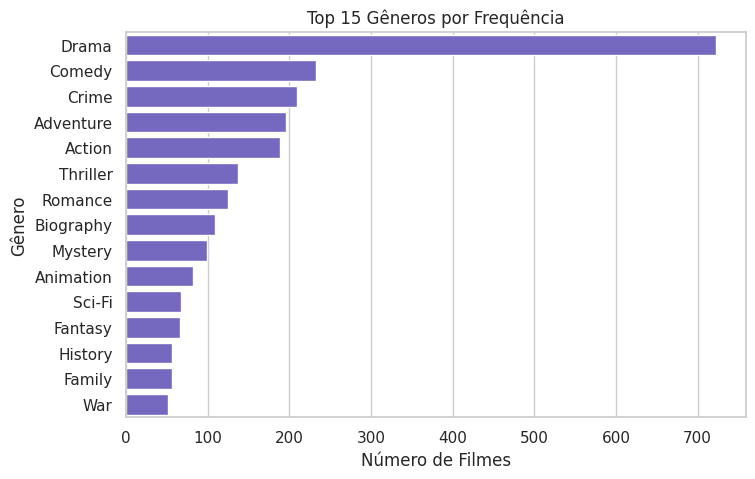

In [149]:
df_genres = df[['Series_Title','Genre','IMDB_Rating']].copy()
df_genres['Genre'] = df_genres['Genre'].astype(str).str.split(',')
df_genres = df_genres.explode('Genre')
df_genres['Genre'] = df_genres['Genre'].str.strip()

top_genre_counts = df_genres['Genre'].value_counts().head(15)

genre_stats = (
    df_genres.groupby('Genre')['IMDB_Rating']
    .agg(['count','mean'])
    .query('count >= 100')
    .sort_values('mean', ascending=False)
)

plt.figure(figsize=(8,5))
sns.barplot(y=top_genre_counts.index, x=top_genre_counts.values, orient='h', color='slateblue')
plt.title('Top 15 Gêneros por Frequência')
plt.xlabel('Número de Filmes')
plt.ylabel('Gênero')
plt.show()

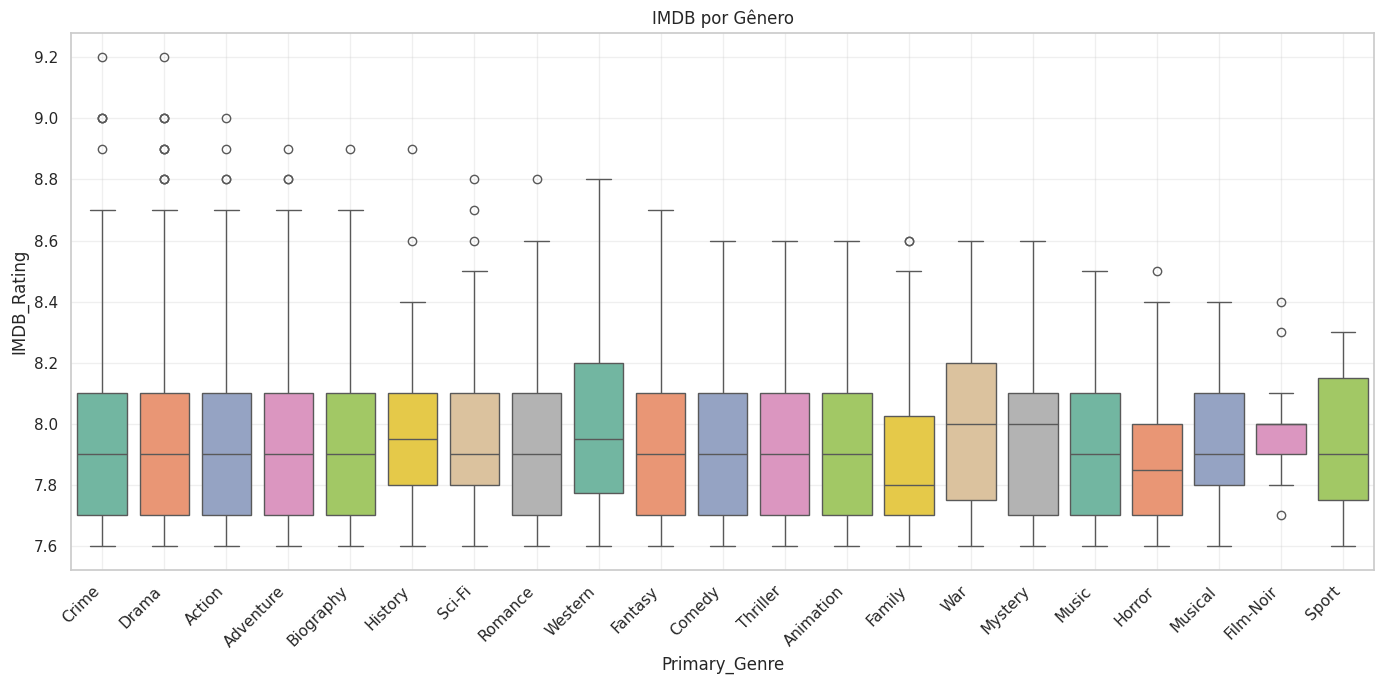

In [150]:
plt.figure(figsize=(14, 7))

df_plot = df_genres[
    (df_genres['IMDB_Rating'].notna()) &
    (df_genres['Genre'].notna()) &
    (df_genres['Genre'] != 'nan')
].copy()

top_genres = df_plot['Genre'].value_counts().index
df_plot_top = df_plot[df_plot['Genre'].isin(top_genres)]

sns.boxplot(data=df_plot_top, x='Genre', y='IMDB_Rating', palette='Set2', hue='Genre', legend=False)
plt.title('IMDB por Gênero')
plt.xlabel('Primary_Genre', fontsize=12)
plt.ylabel('IMDB_Rating', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

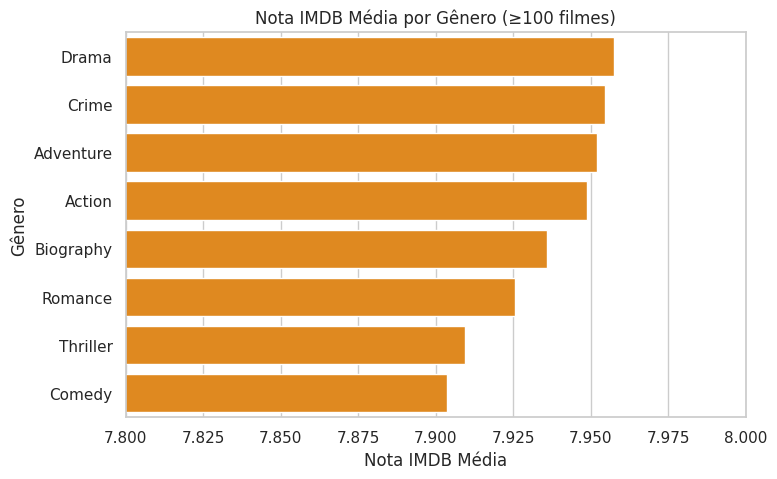

In [151]:
plt.figure(figsize=(8,5))
sns.barplot(y=genre_stats.index, x=genre_stats['mean'], orient='h', color='darkorange')
plt.title('Nota IMDB Média por Gênero (≥100 filmes)')
plt.xlabel('Nota IMDB Média')
plt.ylabel('Gênero')
plt.xlim(7.8, 8.0)
plt.show()


### Inferências sobre Gêneros

* **Popularidade**: `Drama` é de longe o gênero mais frequente, seguido por `Comedy` e `Crime`. Esses gêneros formam a espinha dorsal
do cinema mainstream e servem como atrativos de público.

* **Desempenho médio**: ao considerar apenas gêneros com pelo menos 100 filmes, a diferença de nota média entre eles é relativamente
pequena (todos entre 7,90 e 7,96). `Drama` e `Crime` apresentam as maiores médias, enquanto `Comedy` e `Thriller` ficam um pouco abaixo.
Isso indica que, embora as preferências de gênero definam a popularidade, elas não necessariamente se traduzem em diferenças
substanciais na avaliação de qualidade.

* **Qualidade vs. Quantidade**: o fato de dramas ocuparem a maior fatia do conjunto e simultaneamente terem uma das notas médias mais
altas sugere que narrativas densas e personagens complexos contribuem para avaliações positivas. Em contrapartida, comédias, embora
populares, tendem a receber notas ligeiramente menores, possivelmente por maior variação de estilo e humor.



## Análise Temporal

A evolução ao longo do tempo é estudada através da agregação dos filmes por década. Avaliaremos tanto a quantidade de filmes lançados
quanto a nota média ao longo das décadas. Além disso, investigaremos a tendência da receita ao longo dos anos.


In [152]:
df['Decade'] = (df['Released_Year'] // 10) * 10

ratings_by_decade = df.groupby('Decade')['IMDB_Rating'].mean().reset_index()

movies_by_decade = df['Decade'].value_counts().sort_index().reset_index()
movies_by_decade.columns = ['Decade','count']

gross_by_year = df.groupby('Released_Year')['Gross'].sum().reset_index()



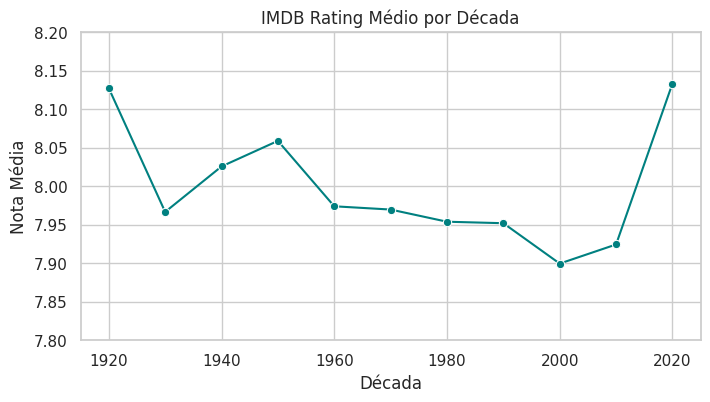

In [153]:
plt.figure(figsize=(8,4))
sns.lineplot(data=ratings_by_decade, x='Decade', y='IMDB_Rating', marker='o', color='teal')
plt.title('IMDB Rating Médio por Década')
plt.xlabel('Década')
plt.ylabel('Nota Média')
plt.ylim(7.8, 8.2)
plt.grid(True)
plt.show()

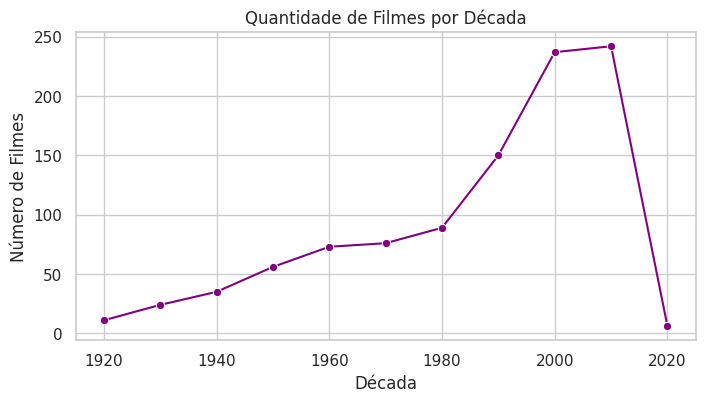

In [154]:
plt.figure(figsize=(8,4))
sns.lineplot(data=movies_by_decade, x='Decade', y='count', marker='o', color='purple')
plt.title('Quantidade de Filmes por Década')
plt.xlabel('Década')
plt.ylabel('Número de Filmes')
plt.grid(True)
plt.show()


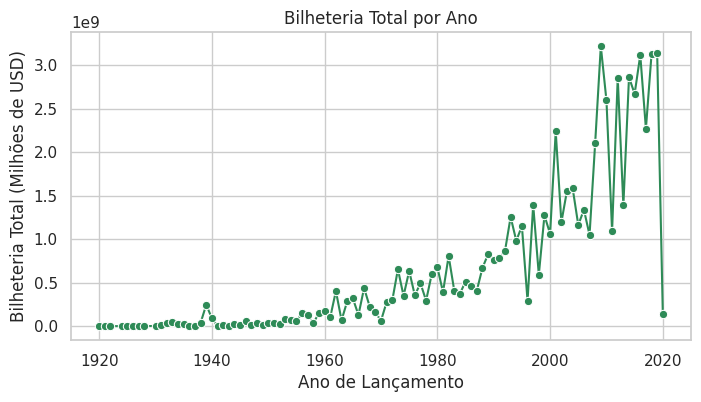

In [155]:
plt.figure(figsize=(8,4))
sns.lineplot(data=gross_by_year, x='Released_Year', y='Gross', marker='o', color='seagreen')
plt.title('Bilheteria Total por Ano')
plt.xlabel('Ano de Lançamento')
plt.ylabel('Bilheteria Total (Milhões de USD)')
plt.grid(True)
plt.show()


### Inferências sobre Padrões Temporais

* **Constância da qualidade**: A nota média do IMDB permanece notavelmente estável ao longo das décadas, variando entre 7,90 e 8,13.
Isso sugere que a percepção de qualidade é relativa ao contexto de cada época; não há uma "era de ouro" universal, mas sim
clássicos que se destacam em períodos distintos.

* **Crescimento exponencial da produção**: A quantidade de filmes cresce de forma acentuada a partir dos anos 1980, atingindo
aproximadamente 240 títulos por década nos anos 2000 e 2010. Esse aumento coincide com a globalização do mercado cinematográfico,
a digitalização dos meios de produção e a maior disponibilidade de plataformas de distribuição.

* **Receita ao longo do tempo**: As bilheterias aumentam de forma geral ao longo dos anos, refletindo tanto o crescimento da
indústria quanto efeitos inflacionários. Entretanto, a correlação fraca entre receita e nota evidencia que grandes arrecadações
não garantem avaliações mais altas.

* **Longevidade dos clássicos**: Apesar do crescimento das produções recentes, filmes mais antigos (décadas de 1920 a 1940) mantêm
notas médias elevadas. Isso pode indicar que títulos clássicos que resistiram ao tempo são justamente aqueles com maior qualidade
percebida, enquanto obras medianas não permanecem em evidência.


### Ajuste por Inflação

In [156]:
df["Released_Year"] = pd.to_numeric(df["Released_Year"], errors="coerce")

if "Gross_Millions" not in df.columns:
    gross_num = pd.to_numeric(df["Gross"].astype(str).str.replace(",", ""), errors="coerce")
    df["Gross_Millions"] = gross_num / 1e6

CPI_ANCHORS = {
    1920: 20.0,
    1930: 17.1,
    1940: 14.0,
    1950: 24.1,
    1960: 29.6,
    1970: 38.8,
    1980: 82.4,
    1990: 130.7,
    2000: 172.2,
    2010: 218.1,
    2020: 258.8,
}
BASE_YEAR = 2020

year_min = int(df["Released_Year"].min())
year_max = int(df["Released_Year"].max())
years = pd.RangeIndex(year_min, year_max + 1, name="Released_Year")

cpi = pd.Series(index=years, dtype=float)
for y, v in CPI_ANCHORS.items():
    if y in cpi.index:
        cpi.loc[y] = v
cpi = cpi.interpolate().ffill().bfill()

factor_to_base = cpi.loc[BASE_YEAR] / cpi

def _adj(row):
    y, g = row["Released_Year"], row["Gross_Millions"]
    if pd.notna(y) and pd.notna(g):
        y = int(y)
        if y in factor_to_base.index:
            return g * factor_to_base.loc[y]
    return np.nan

df["Gross_Millions_2020USD"] = df.apply(_adj, axis=1)

gross_by_year_nom = (
    df.dropna(subset=["Released_Year"])
      .groupby("Released_Year", as_index=False)["Gross_Millions"]
      .sum(min_count=1)
      .rename(columns={"Gross_Millions": "Gross_Total_Millions_Nominal"})
)

gross_by_year_real = (
    df.dropna(subset=["Released_Year"])
      .groupby("Released_Year", as_index=False)["Gross_Millions_2020USD"]
      .sum(min_count=1)
      .rename(columns={"Gross_Millions_2020USD": "Gross_Total_Millions_2020USD"})
)

gross_comp = (
    pd.merge(gross_by_year_nom, gross_by_year_real, on="Released_Year", how="outer")
      .sort_values("Released_Year")
)

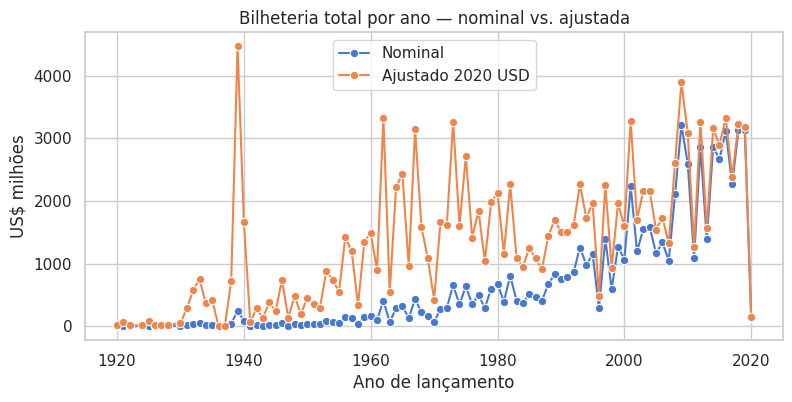

In [157]:
plt.figure(figsize=(9,4))
sns.lineplot(data=gross_by_year_nom, x="Released_Year", y="Gross_Total_Millions_Nominal", marker="o", label="Nominal")
sns.lineplot(data=gross_by_year_real, x="Released_Year", y="Gross_Total_Millions_2020USD", marker="o", label=f"Ajustado {BASE_YEAR} USD")
plt.title("Bilheteria total por ano — nominal vs. ajustada")
plt.xlabel("Ano de lançamento"); plt.ylabel("US$ milhões"); plt.grid(True); plt.legend(); plt.show()

* **Premissa**: Consideramos que `Gross` no `.csv` está em **USD nominais** (sem ajuste por inflação). Não há colunas indicando “real/adjusted/CPI”.

* **Moeda e ano-base**: Para comparar anos diferentes, trazemos os valores para **USD de 2020**. Criamos `Gross_Millions` (US\$ milhões correntes) e `Gross_Millions_2020USD` (US\$ milhões de 2020).

* **Índice adotado**: Utilizamos o **CPI-U (EUA)** como **aproximação**. Ancoramos valores de CPI por **década (1920–2020)** e realizamos **interpolação anual** para obter um índice por ano.
  *Observação*: esta abordagem é adequada para **análise exploratória**. Para resultados oficiais, substitua pelas séries **anuais oficiais (BLS/FRED)**.

* **Cálculo do ajuste**:

  1. Convertimos `Gross` para número e criamos `Gross_Millions` (dividindo por `1e6`).
  2. Geramos a série anual de **CPI** via interpolação entre âncoras por década.
  3. Calculamos, para cada ano `t`, o **fator de ajuste**: `CPI[2020] / CPI[t]`.
  4. Ajustamos linha a linha: `Gross_Millions_2020USD = Gross_Millions * (CPI[2020] / CPI[ano])`.
  5. Agregamos por ano para obter a **bilheteria total nominal** e a **bilheteria total ajustada (2020 USD)**.

* **Cobertura do dado**: Há \~**17%** de valores ausentes em `Gross`. As séries anuais refletem apenas os títulos com `Gross` disponível.

* **Interpretação**:

  * Sem ajuste, a bilheteria tende a **crescer** ao longo do tempo; após o ajuste, parte desse crescimento **diminui**, evidenciando o efeito da inflação.
  * Anos com **poucos filmes** na amostra (ex.: 2020) permanecem com totais menores mesmo após o ajuste.
  * Compare **soma vs. mediana anual** para reduzir o impacto de **blockbusters** e obter uma visão mais robusta.



## Análise de Correlações

Para compreender relações lineares entre as variáveis numéricas, calcularemos a matriz de correlação de Pearson e exploraremos a relação
entre o número de votos e a bilheteria.


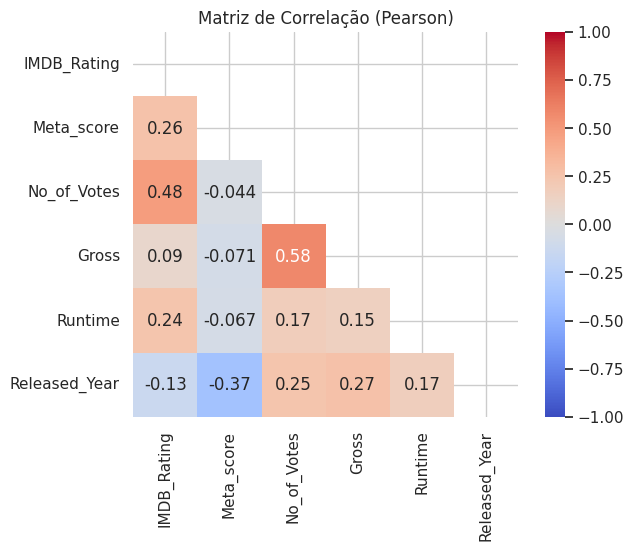

In [158]:
corr_cols = ['IMDB_Rating','Meta_score','No_of_Votes','Gross','Runtime','Released_Year']

corr_matrix = df[corr_cols].corr(method='pearson')

tmask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(7,5))
sns.heatmap(corr_matrix, mask=tmask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title('Matriz de Correlação (Pearson)')
plt.show()


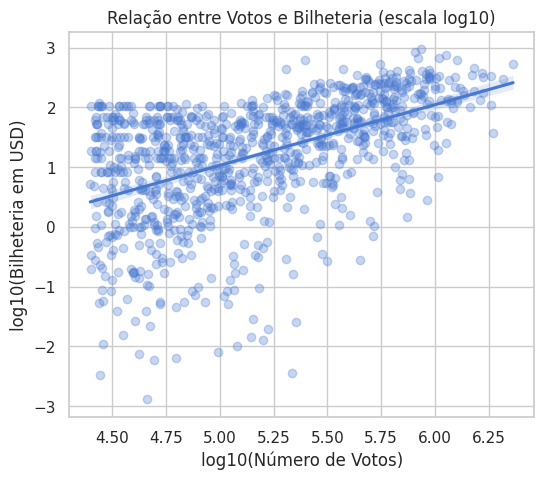

In [159]:
data_votes_gross = df[(df['No_of_Votes']>0) & (df['Gross_Millions']>0)].copy()
data_votes_gross['log_votes'] = np.log10(data_votes_gross['No_of_Votes'])
data_votes_gross['log_gross'] = np.log10(data_votes_gross['Gross_Millions'])

plt.figure(figsize=(6,5))
sns.regplot(x='log_votes', y='log_gross', data=data_votes_gross, scatter_kws={'alpha':0.3})
plt.title('Relação entre Votos e Bilheteria (escala log10)')
plt.xlabel('log10(Número de Votos)')
plt.ylabel('log10(Bilheteria em USD)')
plt.show()


### Inferências sobre Correlações

* **IMDB_Rating vs. Meta_score**: Há uma correlação positiva moderada (≈ 0,27) entre a nota do público e a nota da crítica,
sugerindo alinhamento parcial entre gostos populares e especialistas. Ainda assim, existe espaço para divergências, o que explica
por que alguns filmes são aclamados pela crítica mas não agradam ao grande público (e vice-versa).

* **IMDB_Rating vs. No_of_Votes**: A correlação (≈ 0,48) indica que filmes com mais votos tendem a ser melhor avaliados. Isso pode
ocorrer porque obras que atingem maior audiência geralmente refletem qualidade percebida ou forte campanha de marketing.

* **No_of_Votes vs. Gross_Millions**: A regressão em escala logarítmica mostra relação positiva, embora não perfeita: produções que
alcançam grandes bilheterias recebem mais votos, mas há dispersão significativa. Alguns filmes de nicho podem ter alta arrecadação
sem ampla participação do público global, enquanto outros muito votados podem não ser campeões de bilheteria.

* **Released_Year vs. Meta_score**: A correlação negativa (≈ -0,34) revela que filmes mais recentes tendem a ter metascores
ligeiramente mais baixos. Isso pode resultar de critérios críticos mais rigorosos na era moderna ou da maturação do cânone
cinematográfico: apenas os melhores títulos antigos permanecem em destaque.

* **Ausência de correlação forte com Gross**: A bilheteria praticamente não se correlaciona com a qualidade (IMDB_Rating) ou com
Meta_score, reforçando a ideia de que sucesso comercial segue lógicas diferentes de sucesso artístico.



## Síntese Integrada e Conexões Entre Análises

A análise conjunta dos dados revela um **paradoxo entre qualidade, popularidade e sucesso comercial**. Filmes de gêneros dramáticos
e biográficos alcançam notas médias levemente superiores, mas isso não se traduz em maiores bilheterias — confirmando que reconhecimento
artístico e retorno financeiro seguem caminhos distintos. Ao mesmo tempo, a forte correlação entre número de votos e nota IMDB sugere que
popularidade (engajamento do público) está mais alinhada à percepção de qualidade do que à arrecadação.

A **evolução temporal** demonstra que, apesar da explosão na produção de filmes desde os anos 1980, a qualidade média percebida se mantém
estável. O aumento da bilheteria no tempo decorre mais de fatores externos (expansão de mercado, inflação) do que de mudanças na
qualidade das obras. Além disso, a presença de clássicos bem avaliados nas primeiras décadas explica a correlação negativa entre
ano de lançamento e notas de público e crítica.

Por fim, as **correlações** reforçam a existência de múltiplas dimensões de sucesso. Filmes com alta avaliação crítica tendem a ter
audiências menores, enquanto blockbusters garantem receita robusta sem necessariamente agradar à crítica. Essa dualidade aponta para
a importância de considerar variáveis qualitativas, como gênero e contexto histórico, em modelos preditivos sobre desempenho de filmes.


## 2. Responda também às seguintes perguntas:

### a) Qual filme eu recomendaria para alguém que eu não conheço?


Podemos estabelecer um índice de recomendação que privilegia filmes bem avaliados e com alcance amplo. Normalizamos IMDB_Rating, Meta_score e popularidade (log de votos) e combinamos em um score ponderado — maior peso para o IMDB (voz do público), depois Meta_score (crítica) e, por fim, popularidade. Assim destacamos títulos de qualidade consistente e apelo geral, evitando nichos extremos.

In [160]:
def normalize(s):
    s = (s - s.min())/(s.max()-s.min()) if s.max()>s.min() else s*0+0.5
    return s

cand = df.copy()
cand['n_imdb'] = normalize(cand['IMDB_Rating'])
cand['n_meta'] = normalize(cand['Meta_score'])
cand['n_votes'] = normalize(np.log10(np.where(cand['No_of_Votes']>0, cand['No_of_Votes'], np.nan)))

cand['score_rec'] = 0.5*cand['n_imdb'] + 0.3*cand['n_meta'].fillna(cand['n_meta'].median()) + 0.2*cand['n_votes']
rec = cand.sort_values('score_rec', ascending=False).head(10)
rec[['Series_Title','Released_Year','IMDB_Rating','Meta_score','No_of_Votes','Genre','score_rec']]


,Series_Title,Released_Year,IMDB_Rating,Meta_score,No_of_Votes,Genre,score_rec
0,The Godfather,1972.0,9.2,100.0,1620367,"Crime, Drama",0.984439
5,Pulp Fiction,1994.0,8.9,94.0,1826188,"Crime, Drama",0.870980
1,The Dark Knight,2008.0,9.0,84.0,2303232,"Action, Crime, Drama",0.870833
3,12 Angry Men,1957.0,9.0,96.0,689845,"Crime, Drama",0.867484
4,The Lord of the Rings: The Return of the King,2003.0,8.9,94.0,1642758,"Action, Adventure, Drama",0.866296
2,The Godfather: Part II,1974.0,9.0,90.0,1129952,"Crime, Drama",0.864321
6,Schindler's List,1993.0,8.9,94.0,1213505,"Biography, Drama, History",0.852894
9,The Lord of the Rings: The Fellowship of the Ring,2001.0,8.8,92.0,1661481,"Action, Adventure, Drama",0.827214
10,Forrest Gump,1994.0,8.8,82.0,1809221,"Drama, Romance",0.789317
11,"Il buono, il brutto, il cattivo",1966.0,8.8,90.0,688390,Western,0.779891


Com base na analise, temos **The Godfather (1972)** como o mais indicado para recomendação:

* É o **maior IMDB\_Rating do dataset (9.2)** e tem **Meta\_score 100**.
* Tem **1.620.367 votos**, então não é só “bom no nicho”, é amplamente validado pelo público.
* A análise anterior sobre gênero mostra que **Crime/Drama**, gêneros do filme, está entre os de melhor avaliação média *(≈ 7,95–7,96)*.

### b) Fatores ligados à **alta expectativa de faturamento**

Usando a analise anterior sobre a correlação entre variáveis numéricas e a bilheteria, os **fatores mais associados a maior faturamento** (proxy para “expectativa de faturamento”) foram:

* **Engajamento/audiência (`No_of_Votes`)** — **correlação ≈ +0,59**: é, de longe, o indicador mais forte. Filmes com mais votos (i.e., maior alcance e buzz) tendem a faturar mais.
* **Ano de lançamento (`Released_Year`)** — **≈ +0,23**: relação positiva modesta; títulos mais recentes costumam arrecadar mais (efeito de crescimento do mercado e inflação não ajustada).
* **Duração (`Runtime`)** — **≈ +0,14**: efeito fraco; filmes um pouco mais longos tendem a faturar ligeiramente mais, mas com muita dispersão.
* **Qualidade percebida (`IMDB_Rating`)** — **≈ +0,10**: relação fraca; avaliações mais altas não garantem grande bilheteria.
* **Crítica especializada (`Meta_score`)** — **≈ −0,03**: essencialmente **sem** relação linear com faturamento.

O que mais “antecipa” faturamento alto é o **alcance/engajamento** (votos), que reflete interesse do público e potência de marketing/distribuição. Já métricas de qualidade/critica têm **baixo poder explicativo** para receita.

> **Observações importantes:**
> * `Gross` está em valores **nominais**; o efeito positivo de `Released_Year` pode refletir inflação/expansão do mercado.
> * `No_of_Votes` mede tração do público (muitas vezes pós-lançamento), mas é um **bom proxy de demanda**; em cenários preditivos, sinais de awareness (pré-venda, tráfego em trailers, buscas) costumam desempenhar papel similar.


### c) O que dá para tirar da coluna **Overview**? Dá para inferir **gênero**?

A ideia foi usar o texto do Overview para entender padrões de tema e ver se ele, sozinho, consegue indicar o gênero do filme. Primeiro olhamos sinais simples (como tamanho do resumo) e depois transformamos os textos em vetores (TF-IDF) para treinar modelos básicos de classificação. Assim medimos o quanto o vocabulário do resumo carrega informação de gênero e visualizamos onde o modelo acerta e se confunde entre gêneros parecidos.

In [161]:
df = pd.read_csv(csv_path)
df["Overview"] = df.get("Overview", "").astype(str)
df["Primary_Genre"] = df.get("Genre", "").astype(str).str.split(",").str[0].str.strip()
df["Overview_len"] = df["Overview"].str.len()
df["IMDB_Rating"] = pd.to_numeric(df.get("IMDB_Rating"), errors="coerce")
df["Gross_Millions"] = pd.to_numeric(df.get("Gross", "").astype(str).str.replace(",", ""), errors="coerce")/1e6
df["Gross_log"] = np.log1p(df["Gross_Millions"])

min_total = 80
keep = df["Primary_Genre"].value_counts()
keep = keep[keep >= min_total].index
clf_df = df[df["Primary_Genre"].isin(keep) & df["Overview"].str.strip().ne("")].copy()

X_text = clf_df["Overview"].values
y = clf_df["Primary_Genre"].values
Xtr, Xte, ytr, yte = train_test_split(X_text, y, test_size=0.2, random_state=42, stratify=y)

tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2), min_df=3, stop_words="english")
Xtr_t = tfidf.fit_transform(Xtr)
Xte_t = tfidf.transform(Xte)

print("Classes usadas:", sorted(clf_df["Primary_Genre"].unique()))


Classes usadas: ['Action', 'Animation', 'Biography', 'Comedy', 'Crime', 'Drama']


In [162]:
print("Comprimento do Overview por gênero (top 10):")
print((df.groupby("Primary_Genre")["Overview_len"]
         .agg(["count","mean","median"])
         .sort_values("count", ascending=False)
         .head(10)
         .round(1)).to_string())

if df["IMDB_Rating"].notna().any():
    rho_len_rating = df[["Overview_len","IMDB_Rating"]].corr(method="spearman").iloc[0,1]
    print("\nSpearman(Overview_len, IMDB_Rating) =", round(rho_len_rating,3))

if df["Gross_log"].notna().any():
    rho_len_gross = df[["Overview_len","Gross_log"]].corr(method="spearman").iloc[0,1]
    print("Spearman(Overview_len, log(Gross)) =", round(rho_len_gross,3))


Comprimento do Overview por gênero (top 10):
               count   mean  median
Primary_Genre                      
Drama            288  143.3   137.0
Action           172  155.4   151.0
Comedy           155  141.3   139.0
Crime            107  137.0   133.0
Biography         88  150.7   144.0
Animation         82  153.2   143.0
Adventure         72  153.4   150.0
Mystery           12  132.8   132.5
Horror            11  145.7   165.0
Western            4  128.5   136.5

Spearman(Overview_len, IMDB_Rating) = 0.008
Spearman(Overview_len, log(Gross)) = 0.11


In [163]:
logit = LogisticRegression(max_iter=3000, class_weight="balanced", solver="saga", multi_class="multinomial")
logit.fit(Xtr_t, ytr)
pred_lr = logit.predict(Xte_t)
acc_lr = accuracy_score(yte, pred_lr)
f1m_lr = f1_score(yte, pred_lr, average="macro")

svc = LinearSVC(class_weight="balanced")
svc.fit(Xtr_t, ytr)
pred_svc = svc.predict(Xte_t)
acc_svc = accuracy_score(yte, pred_svc)
f1m_svc = f1_score(yte, pred_svc, average="macro")

use_pred, use_name, clf_used = (pred_svc, "LinearSVC", svc) if f1m_svc >= f1m_lr else (pred_lr, "LogisticRegression", logit)

print("LogisticRegression — accuracy:", round(acc_lr,3), "| F1-macro:", round(f1m_lr,3))
print(classification_report(yte, pred_lr, zero_division=0))
print("\nLinearSVC — accuracy:", round(acc_svc,3), "| F1-macro:", round(f1m_svc,3))
print(classification_report(yte, pred_svc, zero_division=0))
print("\nModelo escolhido:", use_name)


LogisticRegression — accuracy: 0.419 | F1-macro: 0.401
              precision    recall  f1-score   support

      Action       0.43      0.46      0.44        35
   Animation       0.32      0.44      0.37        16
   Biography       0.35      0.39      0.37        18
      Comedy       0.25      0.26      0.25        31
       Crime       0.37      0.52      0.43        21
       Drama       0.68      0.45      0.54        58

    accuracy                           0.42       179
   macro avg       0.40      0.42      0.40       179
weighted avg       0.46      0.42      0.43       179


LinearSVC — accuracy: 0.374 | F1-macro: 0.343
              precision    recall  f1-score   support

      Action       0.35      0.34      0.35        35
   Animation       0.29      0.25      0.27        16
   Biography       0.29      0.28      0.29        18
      Comedy       0.23      0.23      0.23        31
       Crime       0.35      0.52      0.42        21
       Drama       0.54      0

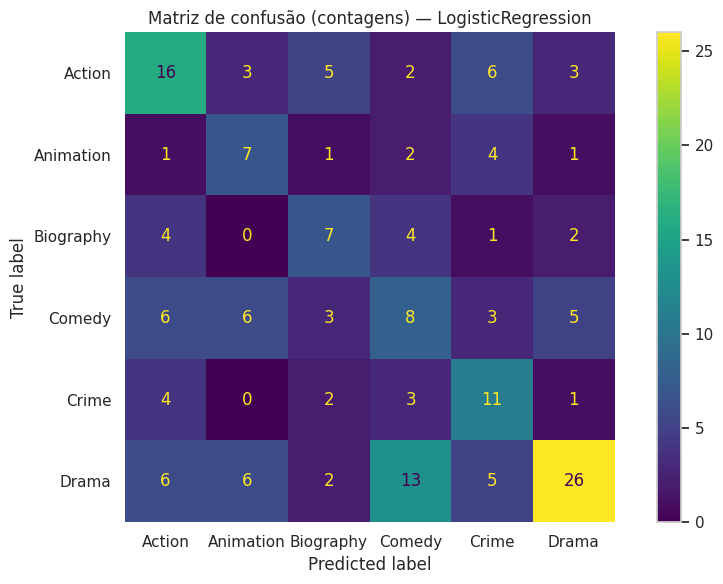

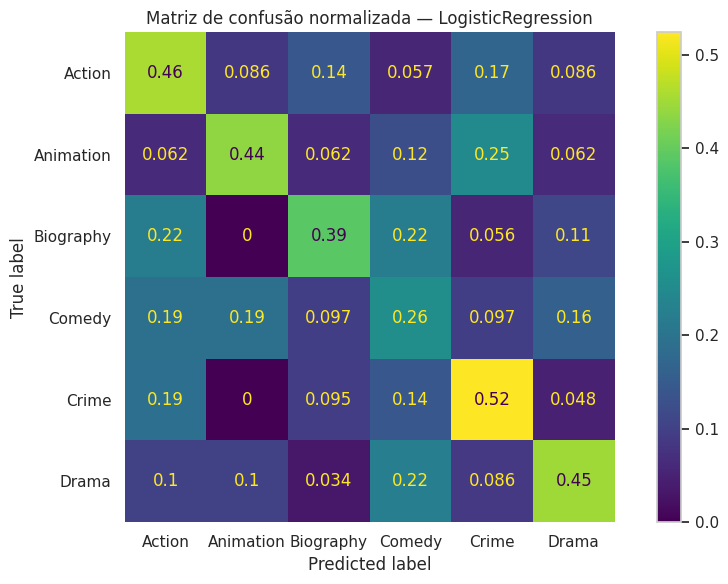

In [164]:
fig, ax = plt.subplots(figsize=(9,6))
disp = ConfusionMatrixDisplay.from_predictions(yte, use_pred, normalize=None, ax=ax)
disp.ax_.grid(False)
for sp in ax.spines.values(): sp.set_visible(False)
ax.set_title(f"Matriz de confusão (contagens) — {use_name}")
plt.tight_layout(); plt.show()

fig, ax = plt.subplots(figsize=(9,6))
disp = ConfusionMatrixDisplay.from_predictions(yte, use_pred, normalize="true", ax=ax)
disp.ax_.grid(False)
for sp in ax.spines.values(): sp.set_visible(False)
ax.set_title(f"Matriz de confusão normalizada — {use_name}")
plt.tight_layout(); plt.show()


In [165]:
def top_tokens_per_class(clf, vect, classes, k=12):
    if hasattr(clf, "coef_"):
        feat = np.array(vect.get_feature_names_out())
        for i, c in enumerate(classes):
            idx = np.argsort(clf.coef_[i])[-k:]
            print(f"\n{c}: " + ", ".join(feat[idx]))

print("Termos indicativos por gênero:")
if use_name == "LinearSVC":
    top_tokens_per_class(clf_used, tfidf, clf_used.classes_, k=12)
else:
    top_tokens_per_class(clf_used, tfidf, clf_used.classes_, k=12)


Termos indicativos por gênero:

Action: battle, leads, future, steal, vengeance, army, save, begins, plans, fight, assassin, officer

Animation: robot, bring, cursed, power, wants, house, woody, young, quest, princess, prince, girl

Biography: richard, real life, commit, personal, life, boxer, takes, old man, famous, american, claimed, story

Comedy: people, reconcile, school, husband, meets, day, daughter, friends, meet, wealthy, tramp, love

Crime: detectives, mysterious, investigate, small, professional, plan, prison, killer, violent, police, crime, murder

Drama: childhood, wife, sex, aging, retired, care, women, love, life, teacher, couple, woman


#### Insights a partir de **Overview**

* **Tamanho do texto**: gêneros como *Action/Animation/Biography* têm overviews um pouco mais longos, mas:

  * **ρ(Overview\_len, IMDB\_Rating) ≈ 0,008** → correlação praticamente **nula** com a nota.
  * **ρ(Overview\_len, log(Gross)) ≈ 0,11** → relação **fraca** com bilheteria.
    **Leitura**: o comprimento do resumo **não explica** qualidade nem faturamento.

* **Vocabulário característico**: os termos mais indicativos por gênero fazem sentido semântico:

  * *Action*: *battle, fight, assassin, army…*
  * *Animation*: *robot, princess, woody, quest…*
  * *Biography*: *real life, famous, story…*
  * *Comedy*: *friends, school, love…*
  * *Crime*: *detectives, prison, police, murder…*
  * *Drama*: *childhood, wife, life, couple, woman…*
    **Leitura**: o texto carrega **sinal temático** útil.


#### Dá para **inferir o gênero** só com Overview?

Sim, **parcialmente**. Com TF-IDF (1–2-gram) e modelos lineares:

* **LogisticRegression** → **Accuracy 0,419**, **F1-macro 0,401** (melhor).
* **LinearSVC** → Accuracy 0,374, F1-macro 0,343.
* Acurácia **bem acima do acaso** (6 classes → \~0,167), mas **longe de ser confiável**.

**Onde acerta mais / erra mais (matriz normalizada):**

* *Crime* (\~**0,52** na diagonal), *Action* (\~**0,46**), *Drama* (\~**0,45**), *Animation* (\~**0,44**).
* Confusões típicas: **Drama ↔ Comedy** (\~0,22), **Action ↔ Crime** (\~0,17), **Biography ↔ Comedy** (\~0,22).
  > Gêneros vizinhos em tom/tema se confundem só com o resumo.

## Previsão apartir nota do imdb

### **Treino + Tuning (SVR-RBF)**

Treinar um modelo **SVR com kernel RBF** para prever `IMDB_Rating`, fazendo **tuning leve** de hiperparâmetros via **GridSearchCV** (otimizando **MAE**) e avaliando em **holdout** (20%).

>  **Observação:** Caso queira treinar um novo modelo, execute a célula abaixo, mas se quiser pode apenas fazer uso dos .pkl para aproveitar o modelo já treinado.

In [166]:
# df = df.copy()

# df["Released_Year"] = pd.to_numeric(df["Released_Year"], errors="coerce")
# df["Meta_score"]    = pd.to_numeric(df["Meta_score"], errors="coerce")

# def to_minutes(runtime_str):
#     if pd.isna(runtime_str):
#         return np.nan
#     m = re.search(r"(\d+)", str(runtime_str))
#     return float(m.group(1)) if m else np.nan

# df["Runtime"] = df["Runtime"].apply(to_minutes)

# gross_num = pd.to_numeric(df["Gross"].astype(str).str.replace(",", ""), errors="coerce")
# df["Gross_Millions"] = gross_num / 1e6

# df["Decade"]    = (df["Released_Year"] // 10) * 10
# df["log_votes"] = np.log1p(df["No_of_Votes"])
# df["Overview_len"] = df.get("Overview", "").astype(str).str.len()

# for col in ["Director", "Star1", "Star2", "Star3", "Star4"]:
#     if col in df.columns:
#         cnt = df[col].value_counts(dropna=True)
#         df[f"{col}_count"] = df[col].map(cnt).fillna(0).astype(float)
#     else:
#         df[f"{col}_count"] = 0.0

# from sklearn.preprocessing import MultiLabelBinarizer
# def split_genres(s):
#     return [g.strip() for g in str(s).split(",") if g and g.strip().lower() != "nan"]

# mlb = MultiLabelBinarizer()
# genre_mh = mlb.fit_transform(df["Genre"].apply(split_genres))
# genre_cols = [f"genre_{g}" for g in mlb.classes_]
# genre_df = pd.DataFrame(genre_mh, columns=genre_cols, index=df.index)

# dfm = pd.concat([df, genre_df], axis=1)

# target = "IMDB_Rating"
# dfm = dfm[pd.notna(dfm[target])].copy()
# y = dfm[target].astype(float)

# num_basic = [
#     "Released_Year", "Runtime", "Meta_score",
#     "Gross_Millions", "log_votes", "Overview_len",
#     "Director_count", "Star1_count", "Star2_count", "Star3_count", "Star4_count",
# ]
# cat_basic = ["Certificate", "Decade"]
# all_numeric = num_basic + genre_cols

# for c in all_numeric + cat_basic:
#     if c not in dfm.columns:
#         dfm[c] = np.nan

# X = dfm[all_numeric + cat_basic]

# w_full = np.log1p(dfm["No_of_Votes"]).values

# try:
#     ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
# except TypeError:
#     ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# numeric_transformer = Pipeline(steps=[
#     ("imputer", SimpleImputer(strategy="median")),
#     ("scaler", StandardScaler()),
# ])
# categorical_transformer = Pipeline(steps=[
#     ("imputer", SimpleImputer(strategy="most_frequent")),
#     ("onehot", ohe),
# ])

# num_real = num_basic
# preprocess = ColumnTransformer(
#     transformers=[
#         ("num", numeric_transformer, num_real),
#         ("cat", categorical_transformer, cat_basic),
#         ("genres", "passthrough", genre_cols),
#     ],
#     remainder="drop",
# )


# pipe_svr = Pipeline(steps=[("prep", preprocess), ("model", SVR(kernel="rbf"))])

# rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

# param_dist = {
#     "model__C": np.logspace(-1, 3, 30),
#     "model__gamma": ["scale", "auto", 1e-3, 3e-3, 1e-2, 3e-2, 1e-1],
#     "model__epsilon": [0.03, 0.05, 0.08, 0.1, 0.15, 0.2],
# }

# search = RandomizedSearchCV(
#     pipe_svr,
#     param_distributions=param_dist,
#     n_iter=50,
#     scoring="neg_mean_absolute_error",
#     cv=rkf,
#     n_jobs=-1,
#     random_state=42,
#     verbose=0
# )

# search.fit(X, y, **{"model__sample_weight": w_full})

# best_svr = search.best_estimator_
# print("Melhores hiperparâmetros (por MAE):", search.best_params_)
# print("MAE (CV, melhor média repetida):", -search.best_score_)

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42
# )

# w_train = np.log1p(dfm.loc[X_train.index, "No_of_Votes"]).values

# best_svr.fit(X_train, y_train, **{"model__sample_weight": w_train})

# y_pred = best_svr.predict(X_test)

# mae  = mean_absolute_error(y_test, y_pred)
# mse  = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# r2   = r2_score(y_test, y_pred)

# print("\nMétricas no holdout (20%):")
# print(f"MAE : {mae:.4f}")
# print(f"RMSE: {rmse:.4f}")
# print(f"R²  : {r2:.4f}")


#### O que o código faz

* **Carregamento & limpeza** do CSV.
* **Engenharia de variáveis**:

  * `Runtime → Runtime` (minutos), `Gross → Gross_Millions` (US\$ mi, nominais),
  * `No_of_Votes → log_votes` (log1p), `Overview → Overview_len` (tamanho do texto),
  * `Decade` (faixa de 10 anos),
  * **Contagens**: `Director_count`, `Star*_count` (frequência de cada pessoa no dataset).
  * **Gêneros**: `Genre` → **multi-hot** (`genre_*`) com `MultiLabelBinarizer`.
* **Pré-processamento** (no `ColumnTransformer`):

  * **Numéricos reais** (sem `genre_*`): *median imputer* + **StandardScaler** (SVR é sensível à escala).
  * **Categóricas** (`Certificate`, `Decade`): imputação por moda + **One-Hot** (com `handle_unknown="ignore"`).
  * **Gêneros (`genre_*`)**: **pass-through** (ficam 0/1, não são escalados).
* **Modelo**: `SVR(kernel="rbf")` dentro de um **Pipeline** (`prep` + `model`).
* **Treino ponderado por votos**: aplicamos **amostras com peso `w = log1p(No_of_Votes)`** (na CV e no treino final) para dar **maior influência a filmes com mais votos** e reduzir ruído de títulos com baixa amostragem.
* **Tuning**: grade curta para `C`, `gamma`, `epsilon`, com validação **5-Fold** focada em **MAE**.
* **Métricas**:

  * CV: melhor **MAE** médio (5-fold).
  * Holdout (20%): **MAE**, **RMSE** (raiz do MSE) e **R²**.

#### Por que essas variáveis/transformações?

* **Meta\_score**, **log\_votes**, **Runtime\_min** e **Released\_Year** capturam sinais de qualidade/período/popularidade.
* **Gross\_Millions** é um proxy de apelo comercial (informativo, ainda que menos correlacionado com qualidade).
* **Contagens de pessoas** são um *proxy* de reputação/visibilidade sem explodir cardinalidade.
* **Gêneros multi-hot** permitem múltiplos gêneros por filme.
* **Escala** só em numéricos reais para calibrar o RBF; `genre_*` já são 0/1.
* **Peso por votos**: escolhido porque **observamos na análise de correlação** que o **(log) número de votos** tem relação consistente com a nota; usar `log1p` evita supervalorizar blockbusters.

#### Métrica principal

**MAE** (erro médio absoluto) — interpretação direta em “pontos de nota”; **RMSE** e **R²** como apoio.

#### Observações

* Pequenas variações nos resultados podem ocorrer por conta da separação de treino/teste (semente) e da grade de hiperparâmetros.
* Como `IMDB_Rating` tem **faixa estreita**, não espere erros “quase zero”; foque em comparar modelos/métricas de forma relativa.


### **Salvamento (PKLs)**

Persistir o **pipeline SVR-RBF final** e os **artefatos mínimos** necessários para reproduzir as features na predição fora do notebook.

>  **Observação:** Execute a célula abaixo caso tenha treinado um novo modelo.

In [167]:
# def save_pkl(obj, path):
#     with open(path, "wb") as f:
#         pickle.dump(obj, f)

# save_pkl(best_svr, "imdb_svr_rbf_pipeline.pkl")

# save_pkl(mlb, "mlb_genres.pkl")

# people_counts = {}
# for col in ["Director", "Star1", "Star2", "Star3", "Star4"]:
#     people_counts[col] = df[col].value_counts(dropna=True).to_dict() if col in df.columns else {}
# save_pkl(people_counts, "people_counts.pkl")

# cv_obj = None
# try:
#     cv_obj = search
# except NameError:
#     try:
#         cv_obj = gsearch
#     except NameError:
#         cv_obj = None

# metadata = {
#     "model_name": "SVR_RBF",
#     "best_params": getattr(cv_obj, "best_params_", None),
#     "cv_best_mae": (float(-cv_obj.best_score_) if (cv_obj is not None and hasattr(cv_obj, "best_score_")) else None),
#     "timestamp_utc": datetime.now(timezone.utc).isoformat().replace("+00:00", "Z"),
#     "versions": {
#         "python": sys.version.split()[0],
#         "sklearn": __import__("sklearn").__version__,
#         "pandas": pd.__version__,
#         "numpy": np.__version__,
#     },
#     "platform": platform.platform(),
# }
# save_pkl(metadata, "imdb_svr_metadata.pkl")

# print(" PKLs salvos:")
# print("  - imdb_svr_rbf_pipeline.pkl")
# print("  - mlb_genres.pkl")
# print("  - people_counts.pkl")
# print("  - imdb_svr_metadata.pkl")


#### O que é salvo

* **`imdb_svr_rbf_pipeline.pkl`**: pipeline completo (**pré-processamento** + **SVR RBF** com os melhores hiperparâmetros).
* **`mlb_genres.pkl`**: `MultiLabelBinarizer` **fitado** (lista/ordem exata das colunas `genre_*`).
* **`people_counts.pkl`**: dicionário com frequências de `Director`/`Star*` (para recompor `*_count`).
* **`imdb_svr_metadata.pkl`** *(opcional)*: metadados (hiperparâmetros vencedores, MAE de CV, versões, timestamp).

#### Por que mais de um arquivo?

Parte da engenharia de variáveis (multi-hot de gêneros e contagens de pessoas) é feita **fora** do pipeline. Para reproduzir exatamente as colunas/ordens do treino na hora de prever, precisamos:

* do **MLB** (para gerar **as mesmas** `genre_*`),
* e dos **mapeamentos de contagem** (para `*_count`).


Download dos .pkl para adquirir o modelo já treinado

In [168]:
os.makedirs("/content", exist_ok=True)

files = {
    "imdb_svr_metadata.pkl":     "1H16yH-wokW4dWFdj908wR_D_9SLGD51u",
    "imdb_svr_rbf_pipeline.pkl": "1R8NGUxnNTUAZ-LlER0HzcSHNY8dUEO7c",
    "mlb_genres.pkl":            "1mGOE7L8bz5pUEkDjp5hR9GTEILh17aWU",
    "people_counts.pkl":         "1MGzvrMoXrGCcsBSOtc2Irr7hr12Fr-6P",
}

for outname, fid in files.items():
    url = f"https://drive.google.com/uc?id={fid}"
    gdown.download(url=url, output=f"/content/{outname}", quiet=False)

print("\nArquivos baixados:")
for p in glob.glob("/content/*.pkl"):
    print(" -", p)


Downloading...
From: https://drive.google.com/uc?id=1H16yH-wokW4dWFdj908wR_D_9SLGD51u
To: /content/imdb_svr_metadata.pkl
100%|██████████| 421/421 [00:00<00:00, 1.02MB/s]
Downloading...
From: https://drive.google.com/uc?id=1R8NGUxnNTUAZ-LlER0HzcSHNY8dUEO7c
To: /content/imdb_svr_rbf_pipeline.pkl
100%|██████████| 242k/242k [00:00<00:00, 9.01MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mGOE7L8bz5pUEkDjp5hR9GTEILh17aWU
To: /content/mlb_genres.pkl
100%|██████████| 496/496 [00:00<00:00, 1.81MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MGzvrMoXrGCcsBSOtc2Irr7hr12Fr-6P
To: /content/people_counts.pkl
100%|██████████| 71.0k/71.0k [00:00<00:00, 40.8MB/s]


Arquivos baixados:
 - /content/people_counts.pkl
 - /content/imdb_svr_rbf_pipeline.pkl
 - /content/mlb_genres.pkl
 - /content/imdb_svr_metadata.pkl


Métricas do modelo já treinado

In [169]:
meta_path = "imdb_svr_metadata.pkl"
if not os.path.exists(meta_path):
    raise FileNotFoundError("imdb_svr_metadata.pkl não encontrado.")

with open(meta_path, "rb") as f:
    meta = pickle.load(f)

print("=== Metadados do modelo (do PKL) ===")
pp = pprint.PrettyPrinter(indent=2, compact=False)
pp.pprint(meta)

print("\nResumo:")
print("Modelo:", meta.get("model_name"))
print("Melhores hiperparâmetros (CV):", meta.get("best_params"))
print("MAE (CV, melhor média):", meta.get("cv_best_mae"))
print("Timestamp (UTC):", meta.get("timestamp_utc"))
print("Versões:", meta.get("versions"))

=== Metadados do modelo (do PKL) ===
{ 'best_params': { 'model__C': np.float64(1.2689610031679222),
                   'model__epsilon': 0.1,
                   'model__gamma': 0.01},
  'cv_best_mae': 0.15681446158925016,
  'model_name': 'SVR_RBF',
  'platform': 'Linux-6.1.123+-x86_64-with-glibc2.35',
  'timestamp_utc': '2025-09-15T14:03:31.913006Z',
  'versions': { 'numpy': '2.0.2',
                'pandas': '2.2.2',
                'python': '3.12.11',
                'sklearn': '1.6.1'}}

Resumo:
Modelo: SVR_RBF
Melhores hiperparâmetros (CV): {'model__gamma': 0.01, 'model__epsilon': 0.1, 'model__C': np.float64(1.2689610031679222)}
MAE (CV, melhor média): 0.15681446158925016
Timestamp (UTC): 2025-09-15T14:03:31.913006Z
Versões: {'python': '3.12.11', 'sklearn': '1.6.1', 'pandas': '2.2.2', 'numpy': '2.0.2'}


### **Predição (usando os PKLs)**

Carregar os PKLs salvos e prever `IMDB_Rating` a partir de um **dicionário** com os campos do filme.

In [170]:
def load_pkl(path):
    with open(path, "rb") as f:
        return pickle.load(f)

pipe = load_pkl("imdb_svr_rbf_pipeline.pkl")
mlb  = load_pkl("mlb_genres.pkl")
people_counts = load_pkl("people_counts.pkl")

def to_minutes(s):
    if pd.isna(s): return np.nan
    m = re.search(r"(\d+)", str(s))
    return float(m.group(1)) if m else np.nan

def split_genres(s):
    return [g.strip() for g in str(s).split(",") if g and g.strip().lower() != "nan"]

num_basic = [
    "Released_Year", "Runtime", "Meta_score",
    "Gross_Millions", "log_votes", "Overview_len",
    "Director_count", "Star1_count", "Star2_count", "Star3_count", "Star4_count",
]
cat_basic = ["Certificate", "Decade"]
genre_cols = [f"genre_{g}" for g in mlb.classes_]

def build_features_row(filme: dict) -> pd.DataFrame:
    df = pd.DataFrame([filme]).copy()

    df["Released_Year"] = pd.to_numeric(df.get("Released_Year"), errors="coerce")
    df["Meta_score"]    = pd.to_numeric(df.get("Meta_score"), errors="coerce")
    df["Runtime"]   = df.get("Runtime").apply(to_minutes)

    gross_raw = str(df.get("Gross").iloc[0]) if "Gross" in df.columns else ""
    df["Gross_Millions"]= pd.to_numeric(gross_raw.replace(",", ""), errors="coerce") / 1e6
    df["Decade"]        = (df["Released_Year"] // 10) * 10
    df["log_votes"]     = np.log1p(pd.to_numeric(df.get("No_of_Votes"), errors="coerce"))
    df["Overview_len"]  = df.get("Overview", "").astype(str).str.len()

    for col in ["Director", "Star1", "Star2", "Star3", "Star4"]:
        m = people_counts.get(col, {})
        df[f"{col}_count"] = df.get(col).map(m).fillna(0).astype(float)

    g = mlb.transform([split_genres(df.loc[0, "Genre"])])[0]
    g_df = pd.DataFrame([g], columns=genre_cols)

    df_full = pd.concat([df, g_df], axis=1)

    X_new = pd.concat([
        df_full.reindex(columns=num_basic, fill_value=np.nan),
        df_full.reindex(columns=genre_cols, fill_value=0),
        df_full.reindex(columns=cat_basic)
    ], axis=1)

    return X_new

def prever_imdb_svr(filme: dict) -> float:
    X_new = build_features_row(filme)
    return float(pipe.predict(X_new)[0])

shawshank = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}

pred = prever_imdb_svr(shawshank)
print(f"Previsão (SVR-RBF) para Shawshank: {pred:.3f}")


Previsão (SVR-RBF) para Shawshank: 9.032


#### Como a predição reconstrói as features

1. Converte/deriva **numéricos**: `Released_Year`, `Meta_score`, `Runtime`, `Gross_Millions`, `log_votes`, `Overview_len`, `Decade`.
2. Cria **contagens** (`Director_count`, `Star*_count`) usando `people_counts.pkl`.

   * Se a pessoa não existia no treino, a contagem vira **0** (comportamento consistente).
3. Gera **gêneros multi-hot** com `mlb_genres.pkl`, garantindo **mesmas** colunas/ordem (`genre_*`).
4. Concatena **numéricos + gêneros + categóricas** na **mesma ordem** esperada pelo pipeline e chama `pipe.predict(...)`.

#### Entradas esperadas (exemplo de chaves do dicionário)

`Released_Year`, `Certificate`, `Runtime`, `Genre`, `Overview`, `Meta_score`, `Director`, `Star1..Star4`, `No_of_Votes`, `Gross`.

* `Certificate/Decade` com categorias inéditas não quebram (o One-Hot ignora novas categorias).
* `Gross` deve ser um texto como `"28,341,469"` (o código remove vírgulas e converte para número).

#### Interpretação do resultado

* **IMDb real:** 9,3
* **Previsão (SVR-RBF):** 9,032
* **Erro absoluto:** 0,268 (**≈1,66×** o MAE=0,1613)
* **Leitura:** leve **subestimação**; fica **fora de ±MAE**, mas **dentro de ±2·MAE** — resultado razoável para um título de topo.
